# Imports and set up

In [1]:
import sys
import os

# Go up one level to set the root directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing.sequene_preprocessing import  categorize_sequences, add_sequence_features, validate_sequences
from utility_scripts import plot_confusion_matrix, evaluate_model

In [3]:
FINGERPRINTS_PATH = '/home/dreamtim/Coding/ITMO/itmo-cpp/sequence_representations/morgan_fingerprints.npy'
PROTBERT_PATH = '/home/dreamtim/Coding/ITMO/itmo-cpp/sequence_representations/protbert_embeddings.npy'
BLOMAP_PATH = '/home/dreamtim/Coding/ITMO/itmo-cpp/sequence_representations/blomap_embeddings.npy'

In [4]:
RAW_DATA_PATH = '/home/dreamtim/Coding/ITMO/itmo-cpp/input_data/all_peptides_for_classification.csv'
SEED = 42

In [5]:
%load_ext autoreload
%autoreload 2

# Data loading and preprocessing

In [6]:
peptides_df = pd.read_csv(RAW_DATA_PATH, index_col=0)

clean_peptides_df = (peptides_df.copy()
    .pipe(categorize_sequences)
    .pipe(add_sequence_features)
    .pipe(validate_sequences)
)

clean_peptides_df

,id,sequence,extra_name,cpp_category,is_cpp,cpp_type,origin,id_uptake,peptide,uptake_type,...,standard_sequence,nh3_tail,po3_pos,biotinylated,acylated_n_terminal,cyclic,amidated,stearyl_uptake,hexahistidine_tagged,modifications
0,2721,(Acp)-KKKKKRFSFKKSFKLSGFSFKKNKK,NaN,NaN,True,NaN,NaN,938.0,2721.0,Fluorescence intensity,...,AKKKKKRFSFKKSFKLSGFSFKKNKK,False,False,False,False,False,False,False,False,"[(C, 2), (P, 3)]"
3,2724,(Acp)-RKRRQTSMTDFYHSKRRLIFS,NaN,NaN,True,NaN,NaN,969.0,2724.0,Fluorescence intensity,...,ARKRRQTSMTDFYHSKRRLIFS,False,False,False,False,False,False,False,False,"[(C, 2), (P, 3)]"
7,2761,(biotin)-lclrpvgggweaklakalakalakhlakalakalkacea,NaN,NaN,True,NaN,NaN,1113.0,2761.0,Fluorescence,...,NaN,False,False,True,False,False,False,False,False,[]
8,2762,(biotin)-lclrpvggrsqsrsryyrqrqrsrrrrrrs,NaN,NaN,True,NaN,NaN,1114.0,2762.0,Fluorescence,...,NaN,False,False,True,False,False,False,False,False,[]
9,2630,?A-RR-[KRRRRRE],NaN,NaN,True,NaN,NaN,720.0,2630.0,Relative Mean Fluorescence intensity (%),...,ARRKRRRRRE,False,False,False,False,False,False,False,False,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18348,2355,vrlpppvrlpppvrlppp,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,[]
18349,2360,ykqchkkGGkkGsG,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,GGGG,False,False,False,False,False,False,False,False,"[(Y, 1), (K, 2), (Q, 3), (C, 4), (H, 5), (K, 6..."
18350,2352,"α,ε(Stearyl-AGYLLG)2KINLKALAALAKKIL",NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,SAGYLLGKINLKALAALAKKIL,False,False,False,False,False,False,True,False,"[(T, 2), (E, 3), (A, 4), (R, 5), (Y, 6), (L, 7)]"
18351,2386,δ-(Stearyl-AGYLLG)OINLKALAALAKKIL,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,True,False,"[(T, 2), (E, 3), (A, 4), (R, 5), (Y, 6), (L, 7)]"


In [7]:
fingerprints_embeddings = np.load(FINGERPRINTS_PATH)
print(f"Fingerprints embeddings shape: {fingerprints_embeddings.shape}")
protbert_embeddings = np.load(PROTBERT_PATH)
print(f"ProtBERT embeddings shape: {protbert_embeddings.shape}")
blomap_embeddings = np.load(BLOMAP_PATH)
print(f"Blomap embeddings shape: {blomap_embeddings.shape}")

Fingerprints embeddings shape: (2922, 1024)
ProtBERT embeddings shape: (2922, 1024)
Blomap embeddings shape: (2922, 2959)


In [8]:
assert fingerprints_embeddings.shape[0] == clean_peptides_df.shape[0], "Fingerprints embeddings and peptides DataFrame length mismatch"
assert protbert_embeddings.shape[0] == clean_peptides_df.shape[0], "ProtBERT embeddings and peptides DataFrame length mismatch"
assert blomap_embeddings.shape[0] == clean_peptides_df.shape[0], "Blomap embeddings and peptides DataFrame length mismatch"

### Standard sequence basedd embeddings

In [9]:
SEQUENCE_EMBEDDINGS_COLS = ['protbert', 'blomap']

df_with_sequence_embeddings = clean_peptides_df.copy()
for embeddings, col_name in zip(
    [protbert_embeddings, blomap_embeddings],
    SEQUENCE_EMBEDDINGS_COLS
):
    for i in range(embeddings.shape[1]):
        df_with_sequence_embeddings[f'{col_name}_{i}'] = embeddings[:, i]

df_with_sequence_embeddings = df_with_sequence_embeddings.copy()

# drop columns where standard sequence is Nan
df_with_sequence_embeddings = df_with_sequence_embeddings.dropna(subset=['standard_sequence'])

df_with_sequence_embeddings

/tmp/ipykernel_178490/467849912.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_sequence_embeddings[f'{col_name}_{i}'] = embeddings[:, i]
/tmp/ipykernel_178490/467849912.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_sequence_embeddings[f'{col_name}_{i}'] = embeddings[:, i]
/tmp/ipykernel_178490/467849912.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

,id,sequence,extra_name,cpp_category,is_cpp,cpp_type,origin,id_uptake,peptide,uptake_type,...,blomap_2949,blomap_2950,blomap_2951,blomap_2952,blomap_2953,blomap_2954,blomap_2955,blomap_2956,blomap_2957,blomap_2958
0,2721,(Acp)-KKKKKRFSFKKSFKLSGFSFKKNKK,NaN,NaN,True,NaN,NaN,938.0,2721.0,Fluorescence intensity,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2724,(Acp)-RKRRQTSMTDFYHSKRRLIFS,NaN,NaN,True,NaN,NaN,969.0,2724.0,Fluorescence intensity,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2630,?A-RR-[KRRRRRE],NaN,NaN,True,NaN,NaN,720.0,2630.0,Relative Mean Fluorescence intensity (%),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2629,?A-RRR-[KRRRRE],NaN,NaN,True,NaN,NaN,719.0,2629.0,Relative Mean Fluorescence intensity (%),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,2628,?A-RRRR-[KRRRE],NaN,NaN,True,NaN,NaN,718.0,2628.0,Relative Mean Fluorescence intensity (%),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18343,2714,stearyl-HHHHHHHHHHHHHHHH-RRRRRRRR-NH2,NaN,NaN,True,NaN,NaN,924.0,2714.0,Mean Fluorescence intensity,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18344,2715,stearyl-HHHHHHHHHHHHHHHH-RRRRRRRR-NH3,NaN,NaN,True,NaN,NaN,925.0,2715.0,Mean Fluorescence intensity,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18349,2360,ykqchkkGGkkGsG,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18350,2352,"α,ε(Stearyl-AGYLLG)2KINLKALAALAKKIL",NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_with_sequence_embeddings = df_with_sequence_embeddings.dropna(subset=['standard_sequence'])

In [11]:
df_with_sequence_embeddings

,id,sequence,extra_name,cpp_category,is_cpp,cpp_type,origin,id_uptake,peptide,uptake_type,...,blomap_2949,blomap_2950,blomap_2951,blomap_2952,blomap_2953,blomap_2954,blomap_2955,blomap_2956,blomap_2957,blomap_2958
0,2721,(Acp)-KKKKKRFSFKKSFKLSGFSFKKNKK,NaN,NaN,True,NaN,NaN,938.0,2721.0,Fluorescence intensity,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2724,(Acp)-RKRRQTSMTDFYHSKRRLIFS,NaN,NaN,True,NaN,NaN,969.0,2724.0,Fluorescence intensity,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2630,?A-RR-[KRRRRRE],NaN,NaN,True,NaN,NaN,720.0,2630.0,Relative Mean Fluorescence intensity (%),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2629,?A-RRR-[KRRRRE],NaN,NaN,True,NaN,NaN,719.0,2629.0,Relative Mean Fluorescence intensity (%),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,2628,?A-RRRR-[KRRRE],NaN,NaN,True,NaN,NaN,718.0,2628.0,Relative Mean Fluorescence intensity (%),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18343,2714,stearyl-HHHHHHHHHHHHHHHH-RRRRRRRR-NH2,NaN,NaN,True,NaN,NaN,924.0,2714.0,Mean Fluorescence intensity,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18344,2715,stearyl-HHHHHHHHHHHHHHHH-RRRRRRRR-NH3,NaN,NaN,True,NaN,NaN,925.0,2715.0,Mean Fluorescence intensity,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18349,2360,ykqchkkGGkkGsG,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18350,2352,"α,ε(Stearyl-AGYLLG)2KINLKALAALAKKIL",NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Only embeddings and target
cols_to_use = ['is_cpp'] + [col for col in df_with_sequence_embeddings.columns if col.startswith(tuple(SEQUENCE_EMBEDDINGS_COLS))]
df_with_sequence_embeddings = df_with_sequence_embeddings[cols_to_use]

df_with_sequence_embeddings

,is_cpp,protbert_0,protbert_1,protbert_2,protbert_3,protbert_4,protbert_5,protbert_6,protbert_7,protbert_8,...,blomap_2949,blomap_2950,blomap_2951,blomap_2952,blomap_2953,blomap_2954,blomap_2955,blomap_2956,blomap_2957,blomap_2958
0,True,0.117090,-0.005657,0.068355,0.150962,-0.114639,0.014228,-0.033978,-0.028395,0.018639,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,True,0.083258,-0.014431,0.058178,-0.023437,-0.016820,0.012122,-0.008914,-0.032334,0.058424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,True,0.178444,-0.052987,0.096088,0.064275,-0.137054,0.017732,-0.112436,-0.038191,-0.010401,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,True,0.184009,-0.041006,0.092967,0.063523,-0.144697,-0.005787,-0.124458,-0.020497,0.034472,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,True,0.155055,-0.042447,0.053199,0.030848,-0.131822,0.016709,-0.073527,-0.021612,0.009544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18343,True,0.089998,-0.004560,0.038577,0.074480,-0.100823,-0.003466,-0.002946,0.036589,0.055974,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18344,True,0.089998,-0.004560,0.038577,0.074480,-0.100823,-0.003466,-0.002946,0.036589,0.055974,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18349,True,-0.065103,0.080266,-0.021423,0.187063,-0.139560,0.079650,0.017149,-0.082789,-0.057268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18350,True,0.030537,-0.075554,0.016697,0.068487,-0.023504,0.021028,-0.009828,-0.014498,-0.018020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### SMILES based embeddings

In [13]:
df_with_smiles_embeddings = clean_peptides_df.copy()
for i in range(fingerprints_embeddings.shape[1]):
    df_with_smiles_embeddings[f'fingerprints_{i}'] = fingerprints_embeddings[:, i]

# Only embeddings and target
cols_to_use = ['is_cpp'] + [col for col in df_with_smiles_embeddings.columns if col.startswith('fingerprints')]
df_with_smiles_embeddings = df_with_smiles_embeddings[cols_to_use]

df_with_smiles_embeddings



/tmp/ipykernel_178490/1754371043.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_smiles_embeddings[f'fingerprints_{i}'] = fingerprints_embeddings[:, i]
/tmp/ipykernel_178490/1754371043.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_smiles_embeddings[f'fingerprints_{i}'] = fingerprints_embeddings[:, i]
/tmp/ipykernel_178490/1754371043.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

,is_cpp,fingerprints_0,fingerprints_1,fingerprints_2,fingerprints_3,fingerprints_4,fingerprints_5,fingerprints_6,fingerprints_7,fingerprints_8,...,fingerprints_1014,fingerprints_1015,fingerprints_1016,fingerprints_1017,fingerprints_1018,fingerprints_1019,fingerprints_1020,fingerprints_1021,fingerprints_1022,fingerprints_1023
0,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,True,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18348,True,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
18349,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18350,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18351,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Classification models

In [14]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

In [16]:
results_df = pd.read_csv('results_from_descriptors.csv')
results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Descriptors - Random Forest,0.840074,0.838596,0.853571,0.846018
1,Descriptors - CatBoost,0.834559,0.816667,0.875000,0.844828
2,Descriptors - SVM,0.788603,0.785467,0.810714,0.797891
3,Descriptors - Logistic Regression,0.759191,0.757785,0.782143,0.769772
4,Descriptors - Tuned Random Forest,0.795956,0.951872,0.635714,0.762313
5,Descriptors - Decision Tree,0.748162,0.747405,0.771429,0.759227


In [17]:
results_embeddings = []

### SMILES based embeddings

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df_with_smiles_embeddings.drop(columns=['is_cpp']),
    df_with_smiles_embeddings['is_cpp'],
    test_size=0.2,
    random_state=SEED
)

print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Train target shape: {y_train.shape}, Test target shape: {y_test.shape}")

Train set shape: (2337, 1024), Test set shape: (585, 1024)
Train target shape: (2337,), Test target shape: (585,)


In [19]:
catboost_smiles = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_seed=SEED,
)

In [20]:
catboost_smiles.fit(X_train, y_train, verbose=0)

In [21]:
y_pred = catboost_smiles.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Non-CPP', 'CPP']))
results_embeddings.append(evaluate_model(y_test, y_pred, 'SMILES - CatBoost'))

              precision    recall  f1-score   support

     Non-CPP       0.82      0.81      0.82       267
         CPP       0.84      0.85      0.85       318

    accuracy                           0.83       585
   macro avg       0.83      0.83      0.83       585
weighted avg       0.83      0.83      0.83       585



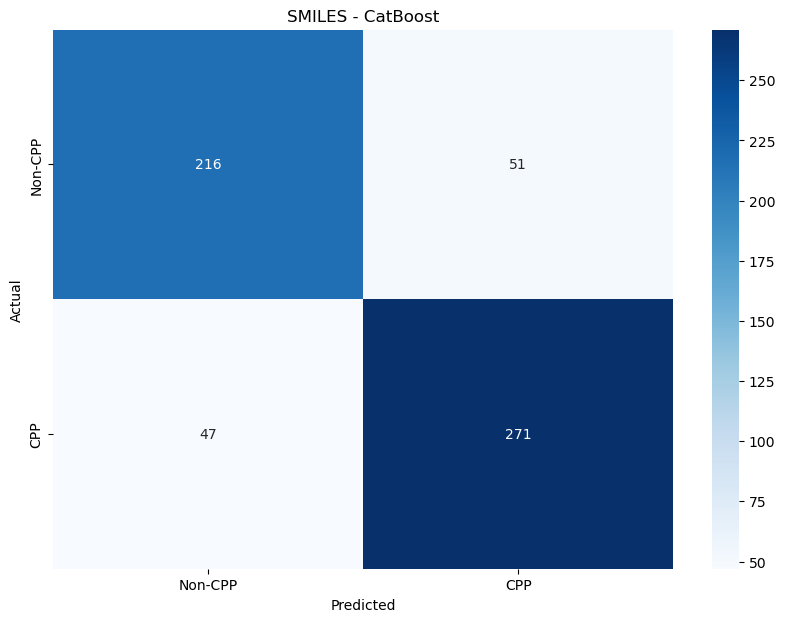

In [22]:
plot_confusion_matrix(y_test, y_pred, labels=['Non-CPP', 'CPP'], title='SMILES - CatBoost')

### Sequence blomap embeddings

In [23]:
cols_to_use = ['is_cpp'] + [col for col in df_with_sequence_embeddings.columns if col.startswith('blomap')]
df_blomap = df_with_sequence_embeddings[cols_to_use]
X_train, X_test, y_train, y_test = train_test_split(
    df_blomap.drop(columns=['is_cpp']),
    df_blomap['is_cpp'],
    test_size=0.2,
    random_state=SEED
)

print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Train target shape: {y_train.shape}, Test target shape: {y_test.shape}")

Train set shape: (2174, 2959), Test set shape: (544, 2959)
Train target shape: (2174,), Test target shape: (544,)


In [24]:
catboost_blomap = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_seed=SEED,
)

catboost_blomap.fit(X_train, y_train, verbose=0)
y_pred = catboost_blomap.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['Non-CPP', 'CPP']))
results_embeddings.append(evaluate_model(y_test, y_pred, 'Blomap - CatBoost'))


              precision    recall  f1-score   support

     Non-CPP       0.82      0.88      0.85       272
         CPP       0.87      0.81      0.84       272

    accuracy                           0.85       544
   macro avg       0.85      0.85      0.85       544
weighted avg       0.85      0.85      0.85       544



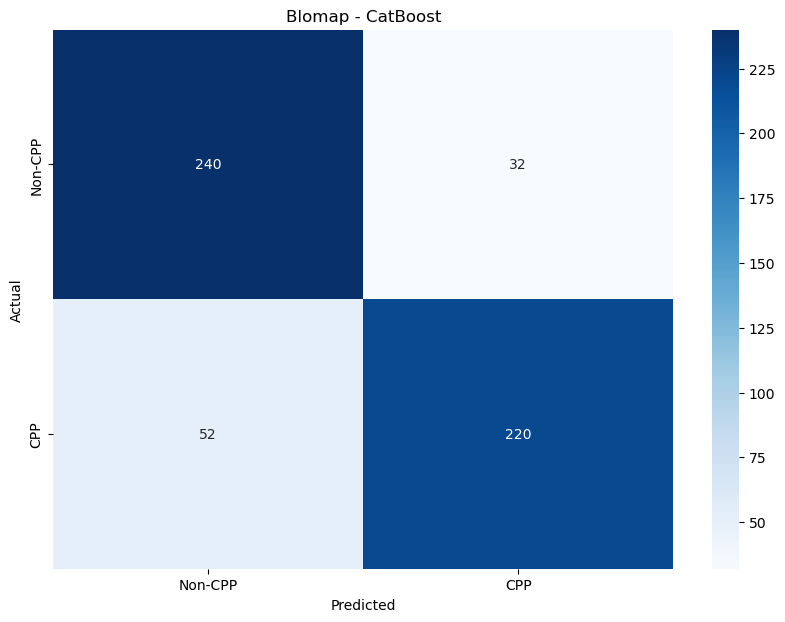

In [25]:
plot_confusion_matrix(y_test, y_pred, labels=['Non-CPP', 'CPP'], title='Blomap - CatBoost')

### Sequence ProtBert embeddings

In [26]:
cols_to_use = ['is_cpp'] + [col for col in df_with_sequence_embeddings.columns if col.startswith('protbert')]

df_protbert = df_with_sequence_embeddings[cols_to_use]
df_protbert

,is_cpp,protbert_0,protbert_1,protbert_2,protbert_3,protbert_4,protbert_5,protbert_6,protbert_7,protbert_8,...,protbert_1014,protbert_1015,protbert_1016,protbert_1017,protbert_1018,protbert_1019,protbert_1020,protbert_1021,protbert_1022,protbert_1023
0,True,0.117090,-0.005657,0.068355,0.150962,-0.114639,0.014228,-0.033978,-0.028395,0.018639,...,0.020847,-0.044005,-0.026207,-0.068921,0.140305,0.019657,0.002898,-0.042757,-0.099386,0.011710
3,True,0.083258,-0.014431,0.058178,-0.023437,-0.016820,0.012122,-0.008914,-0.032334,0.058424,...,0.066482,-0.032610,0.025048,-0.003915,0.096285,-0.001628,-0.016938,-0.040698,0.016143,0.028199
9,True,0.178444,-0.052987,0.096088,0.064275,-0.137054,0.017732,-0.112436,-0.038191,-0.010401,...,0.057151,-0.169420,-0.126746,-0.083246,0.218607,0.052856,0.049310,-0.000901,-0.064998,0.151511
10,True,0.184009,-0.041006,0.092967,0.063523,-0.144697,-0.005787,-0.124458,-0.020497,0.034472,...,0.056038,-0.198622,-0.136129,-0.082397,0.159407,0.055333,0.036571,-0.011674,-0.050898,0.166428
11,True,0.155055,-0.042447,0.053199,0.030848,-0.131822,0.016709,-0.073527,-0.021612,0.009544,...,0.054494,-0.147306,-0.124426,-0.087920,0.171301,0.033224,0.053346,-0.017240,-0.046373,0.115850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18343,True,0.089998,-0.004560,0.038577,0.074480,-0.100823,-0.003466,-0.002946,0.036589,0.055974,...,0.068223,-0.085351,-0.044600,-0.035574,0.081314,-0.006042,-0.023044,0.014715,0.071070,0.084375
18344,True,0.089998,-0.004560,0.038577,0.074480,-0.100823,-0.003466,-0.002946,0.036589,0.055974,...,0.068223,-0.085351,-0.044600,-0.035574,0.081314,-0.006042,-0.023044,0.014715,0.071070,0.084375
18349,True,-0.065103,0.080266,-0.021423,0.187063,-0.139560,0.079650,0.017149,-0.082789,-0.057268,...,0.039453,-0.044236,-0.103969,-0.036106,0.166827,0.007384,0.066592,0.084232,0.054131,0.063138
18350,True,0.030537,-0.075554,0.016697,0.068487,-0.023504,0.021028,-0.009828,-0.014498,-0.018020,...,-0.024639,-0.014541,-0.000361,-0.002592,0.136897,-0.034071,0.016605,-0.000475,-0.047447,0.059731


In [27]:
df_protbert.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2718 entries, 0 to 18352
Columns: 1025 entries, is_cpp to protbert_1023
dtypes: bool(1), float32(1024)
memory usage: 10.6 MB


In [30]:
df_protbert

,is_cpp,protbert_0,protbert_1,protbert_2,protbert_3,protbert_4,protbert_5,protbert_6,protbert_7,protbert_8,...,protbert_1014,protbert_1015,protbert_1016,protbert_1017,protbert_1018,protbert_1019,protbert_1020,protbert_1021,protbert_1022,protbert_1023
0,True,0.117090,-0.005657,0.068355,0.150962,-0.114639,0.014228,-0.033978,-0.028395,0.018639,...,0.020847,-0.044005,-0.026207,-0.068921,0.140305,0.019657,0.002898,-0.042757,-0.099386,0.011710
3,True,0.083258,-0.014431,0.058178,-0.023437,-0.016820,0.012122,-0.008914,-0.032334,0.058424,...,0.066482,-0.032610,0.025048,-0.003915,0.096285,-0.001628,-0.016938,-0.040698,0.016143,0.028199
9,True,0.178444,-0.052987,0.096088,0.064275,-0.137054,0.017732,-0.112436,-0.038191,-0.010401,...,0.057151,-0.169420,-0.126746,-0.083246,0.218607,0.052856,0.049310,-0.000901,-0.064998,0.151511
10,True,0.184009,-0.041006,0.092967,0.063523,-0.144697,-0.005787,-0.124458,-0.020497,0.034472,...,0.056038,-0.198622,-0.136129,-0.082397,0.159407,0.055333,0.036571,-0.011674,-0.050898,0.166428
11,True,0.155055,-0.042447,0.053199,0.030848,-0.131822,0.016709,-0.073527,-0.021612,0.009544,...,0.054494,-0.147306,-0.124426,-0.087920,0.171301,0.033224,0.053346,-0.017240,-0.046373,0.115850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18343,True,0.089998,-0.004560,0.038577,0.074480,-0.100823,-0.003466,-0.002946,0.036589,0.055974,...,0.068223,-0.085351,-0.044600,-0.035574,0.081314,-0.006042,-0.023044,0.014715,0.071070,0.084375
18344,True,0.089998,-0.004560,0.038577,0.074480,-0.100823,-0.003466,-0.002946,0.036589,0.055974,...,0.068223,-0.085351,-0.044600,-0.035574,0.081314,-0.006042,-0.023044,0.014715,0.071070,0.084375
18349,True,-0.065103,0.080266,-0.021423,0.187063,-0.139560,0.079650,0.017149,-0.082789,-0.057268,...,0.039453,-0.044236,-0.103969,-0.036106,0.166827,0.007384,0.066592,0.084232,0.054131,0.063138
18350,True,0.030537,-0.075554,0.016697,0.068487,-0.023504,0.021028,-0.009828,-0.014498,-0.018020,...,-0.024639,-0.014541,-0.000361,-0.002592,0.136897,-0.034071,0.016605,-0.000475,-0.047447,0.059731


In [34]:
df_protbert[df_protbert.duplicated(subset=df_protbert.columns.difference(['is_cpp']))]

,is_cpp,protbert_0,protbert_1,protbert_2,protbert_3,protbert_4,protbert_5,protbert_6,protbert_7,protbert_8,...,protbert_1014,protbert_1015,protbert_1016,protbert_1017,protbert_1018,protbert_1019,protbert_1020,protbert_1021,protbert_1022,protbert_1023
14,True,0.107033,-0.068099,0.091719,0.057635,-0.055587,0.012743,-0.075288,-0.020484,0.002455,...,0.032479,-0.166844,-0.070432,-0.103262,0.190079,0.008296,0.086526,-0.002570,0.003069,0.101096
15,True,0.107033,-0.068099,0.091719,0.057635,-0.055587,0.012743,-0.075288,-0.020484,0.002455,...,0.032479,-0.166844,-0.070432,-0.103262,0.190079,0.008296,0.086526,-0.002570,0.003069,0.101096
23,True,0.041298,-0.061122,0.007958,0.058572,-0.059574,0.036972,-0.027214,-0.031559,0.029085,...,0.029004,0.021068,0.052264,0.001882,0.068271,-0.065296,0.079628,0.018240,-0.094979,0.033499
1994,True,0.036286,-0.018420,0.006227,0.025608,0.022460,0.019165,0.000595,0.080540,0.058211,...,-0.024372,-0.069150,-0.011890,-0.059359,0.065040,0.000923,-0.088167,-0.052820,0.079639,0.040698
1996,True,0.036286,-0.018420,0.006227,0.025608,0.022460,0.019165,0.000595,0.080540,0.058211,...,-0.024372,-0.069150,-0.011890,-0.059359,0.065040,0.000923,-0.088167,-0.052820,0.079639,0.040698
2066,True,0.026064,-0.037989,-0.021327,0.016499,-0.002181,-0.018568,-0.015807,-0.022931,0.054723,...,0.214739,0.038406,-0.007710,-0.045580,0.128771,-0.058772,-0.022876,-0.009337,0.014160,-0.011016
6777,True,-0.030701,-0.074046,0.002057,0.034770,-0.085616,0.016190,0.005396,0.023116,0.003635,...,-0.019719,-0.040807,-0.012172,-0.024629,0.113667,0.007405,-0.011924,0.028298,-0.049959,0.032005
7422,True,0.060969,-0.099752,0.037469,0.047886,-0.095031,-0.062265,-0.089748,-0.013926,0.090761,...,0.019076,-0.090285,-0.074562,-0.029807,0.030162,-0.050290,0.101635,-0.072285,-0.058421,-0.009279
8092,True,0.018268,0.000698,0.014797,0.017759,0.004810,-0.023027,-0.030897,-0.037112,-0.028903,...,0.011922,0.021181,-0.007668,0.015085,0.059152,-0.027455,0.028128,-0.015205,-0.000392,-0.003667
8099,True,0.015497,-0.018652,-0.041340,0.025779,0.005379,0.003057,-0.055918,-0.052847,0.013440,...,0.010569,-0.023099,-0.080615,-0.026035,0.104909,-0.022553,-0.023673,-0.023239,0.007973,-0.015751


In [35]:
assert df_protbert[df_protbert.duplicated(subset=df_protbert.columns.difference(['is_cpp']))].is_cpp.all()

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    df_protbert.drop(columns=['is_cpp']),
    df_protbert['is_cpp'],
    test_size=0.2,
    random_state=SEED
)

print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Train target shape: {y_train.shape}, Test target shape: {y_test.shape}")

Train set shape: (2174, 1024), Test set shape: (544, 1024)
Train target shape: (2174,), Test target shape: (544,)


In [38]:
catboost_protbert = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_seed=SEED,
)

catboost_protbert.fit(X_train, y_train, verbose=0)
y_pred = catboost_protbert.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Non-CPP', 'CPP']))

              precision    recall  f1-score   support

     Non-CPP       0.82      0.80      0.81       272
         CPP       0.81      0.82      0.81       272

    accuracy                           0.81       544
   macro avg       0.81      0.81      0.81       544
weighted avg       0.81      0.81      0.81       544



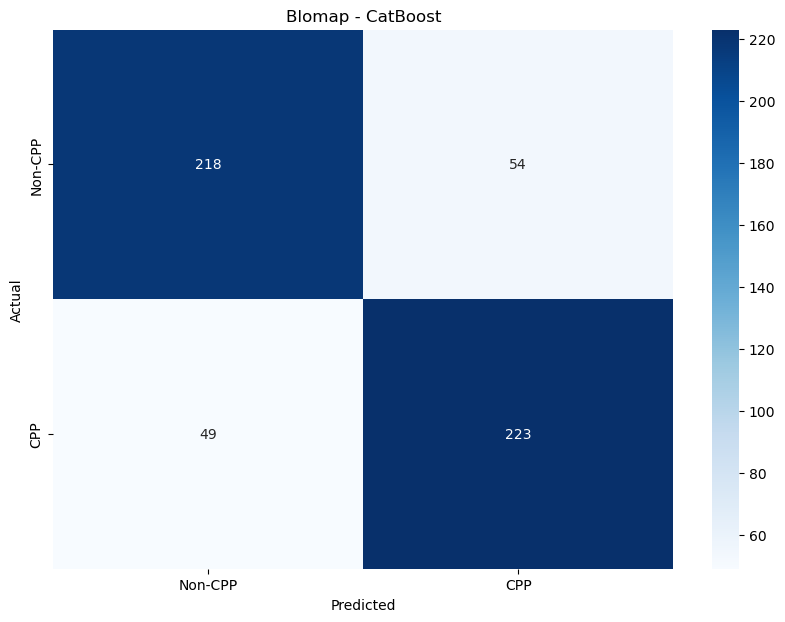

In [39]:
plot_confusion_matrix(y_test, y_pred, labels=['Non-CPP', 'CPP'], title='Blomap - CatBoost')

In [40]:
results_embeddings.append(evaluate_model(y_test, y_pred, 'ProtBERT - CatBoost'))

In [44]:
pipe = make_pipeline(
        StandardScaler(),
        PCA(n_components=128, random_state=42),
        CatBoostClassifier(
            iterations=1000,
            learning_rate=0.1,
            depth=6,
            random_seed=SEED,
            verbose=0
        )
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Non-CPP', 'CPP']))

              precision    recall  f1-score   support

     Non-CPP       0.81      0.78      0.79       272
         CPP       0.79      0.82      0.80       272

    accuracy                           0.80       544
   macro avg       0.80      0.80      0.80       544
weighted avg       0.80      0.80      0.80       544



Dimensionality reduction doesn't benifit the model performance.

In [45]:
results_embeddings.append(evaluate_model(y_test, y_pred, 'ProtBERT - PCA + CatBoost'))

### Models comparison

In [46]:
results_embeddings_df = pd.DataFrame(results_embeddings)
results_embeddings_df

,Model,Accuracy,Precision,Recall,F1-Score
0,SMILES - CatBoost,0.832479,0.841615,0.852201,0.846875
1,Blomap - CatBoost,0.845588,0.873016,0.808824,0.839695
2,ProtBERT - CatBoost,0.810662,0.805054,0.819853,0.812386
3,ProtBERT - PCA + CatBoost,0.797794,0.785211,0.819853,0.802158


In [48]:
all_results_df = pd.concat([results_df, results_embeddings_df], ignore_index=True)
all_results_df.sort_values(by='F1-Score', ascending=False, inplace=True)
all_results_df

,Model,Accuracy,Precision,Recall,F1-Score
6,SMILES - CatBoost,0.832479,0.841615,0.852201,0.846875
0,Descriptors - Random Forest,0.840074,0.838596,0.853571,0.846018
1,Descriptors - CatBoost,0.834559,0.816667,0.875000,0.844828
7,Blomap - CatBoost,0.845588,0.873016,0.808824,0.839695
8,ProtBERT - CatBoost,0.810662,0.805054,0.819853,0.812386
9,ProtBERT - PCA + CatBoost,0.797794,0.785211,0.819853,0.802158
2,Descriptors - SVM,0.788603,0.785467,0.810714,0.797891
3,Descriptors - Logistic Regression,0.759191,0.757785,0.782143,0.769772
4,Descriptors - Tuned Random Forest,0.795956,0.951872,0.635714,0.762313
5,Descriptors - Decision Tree,0.748162,0.747405,0.771429,0.759227


In [ ]:
all_results_df.to_csv('results_with_embeddings.csv', index=False)

It turns out that more general SMILES based model has the same perfomance as the best descriptor based model, which is great, since it can be used on more diverse datasets.